# Hopfield model with $1$-D patterns

The Hopfield model is a model of neuron dynamics, in this project we mapped our network in a spin system with inhomogeneous couplings. The full Hamiltonian of the system is $H[S] = - \sum_{i<j} J_{ij}S_iS_j$. The network in practice is used to store patterns, a pattern $x^i = \{S_j\}_{j=1,...N}$ is a given configuration of the system, with $S_j = \pm 1$.

The aim of this part of the project is to show that the network can store $P$ different patterns and, furthermore, given a corrupted pattern $y^a$ (i.e. a pattern $y^a_i = x^a_i$ with probability $q<1$, otherwise $y^a_i = -x^a_i$ with probability $1-q$) it can reconstruct the original pattern $x^a$ with the 'sign' rule.

This rule is implemented using the so-called iterating sign rule: each spin at iteration $t+1$ is: 


$$
\begin{cases}
S_i(t+1) = \sum_j J_{ij}S_j(t) \\
S(0)=y^a
\end{cases}
$$



In [1]:
import numpy as np
from numpy import random
from matplotlib import pyplot as plt
from scipy import optimize
from scipy import interpolate
from keras.datasets import mnist

The couplings matrix is:

$$
J_{ij} = \frac{1}{N}\sum_{a=1}^P x_j^a x_i^a 
$$
This matrix represents the coupling interaction between all the spins, using the Hebb rule (neglecting the self interaction):

$$
J_{ii} = 0
$$

In [2]:
def J(M):
    
    matrix_dim = M.shape
    J          = np.zeros((matrix_dim[1],matrix_dim[1]))

    for i in range(0,matrix_dim[1]):
        for j in range(0,matrix_dim[1]):
            if j!=i:
                J[i,j] = np.sum([M[a,i]*M[a,j] for a in range(0,matrix_dim[0])])/matrix_dim[1]
    return J

The input of our model is a set of randomly generated arrays containing $+1$ and $-1$, stored in a $P \times N$ matrix $M$. All the pattern must be different one another.

In [3]:
def Create_M(P,N):
    
    M = np.zeros((P,N))
    k = 0
    
    for i in range(0,P):
        k = 0
        while True:
            k = 0
            M[i] = np.random.choice([-1,1],size=N)
            for j in range(0,i): 
                if (M[i]==M[j]).all()==True:
                    k += 1 
            if k==0:
                break        
    return M


print(Create_M(3,5)) #to show what kind of patterns we have

[[ 1. -1. -1.  1.  1.]
 [ 1. -1.  1. -1. -1.]
 [-1.  1. -1.  1.  1.]]


In [4]:
def Wrong_patterns(q,M):

    Y = np.zeros((M.shape))

    for i in range(0,M.shape[0]):
        x = M[i,:]
        for j in range(0,M.shape[1]):
            rand = np.random.random_sample()
            if rand<=q:
                Y[i,j] = x[j] 
            else:
                Y[i,j] = -x[j]
                
    return Y                    #return a matrix Y of corrupted patterns

In [5]:
def Update_y(J,y,M,iter_max=100):
    
    flag = 1
    t    = 0
                                                # Update
    y_old    = np.zeros(len(y))
    y_old[:] = y[:]
    while flag and t <= iter_max :
        for i in range(J.shape[1]):
            y[i] = np.sign(np.dot(J[i,:],y)) 
            if y[i]==0:                        #y_i = 0 --> np.sign(0) = 0 --> we put y_i = 1
                y[i] = 1
        t += 1
        k  = 0
        for j in range(0,len(y)):
            if(y[j] == y_old[j]):
                k += 1
        if k==len(y):
            flag = 0
        else:
            y_old[:] = y[:]
                
                                                # Pattern of y updated
    P_a = -1
    if flag == 0:
        for i in range(M.shape[0]):
            k = 0
            for j in range(0,len(y)):
                if(y[j] == M[i,j]):
                    k += 1
            if k == len(y):
                P_a = i
                
    return P_a,t

# Statistics on the patterns

In this cell we cycle over the number of patterns (incrementing it), with the number of spins fixed ($N=100$). We created the matrices $M$ and $J$, and we increased the probability $q$ with different length steps. 

In [6]:
def mov_avg(x, w):
    
    x_n = np.zeros(len(x))
    for m in range(len(x)-(w-1)):
        x_n[m] = sum(np.ones(w) * x[m:m+w]) / w 
        
    return x_n

Number of pattern:5


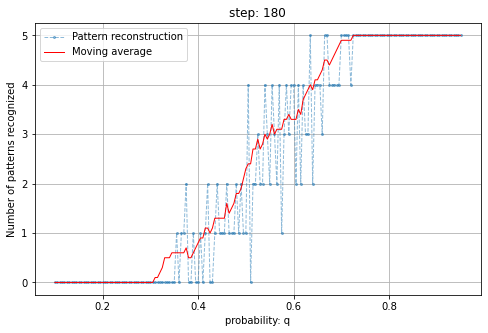

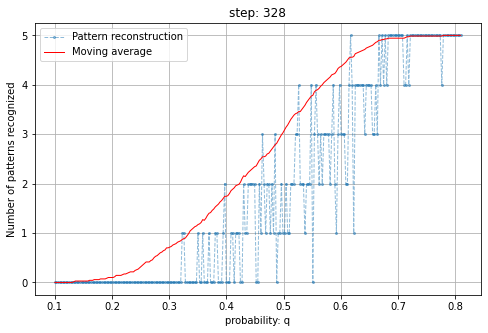

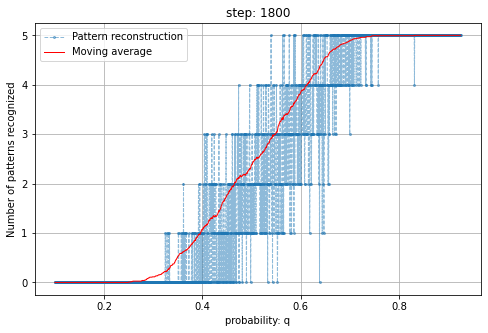

Number of pattern:10


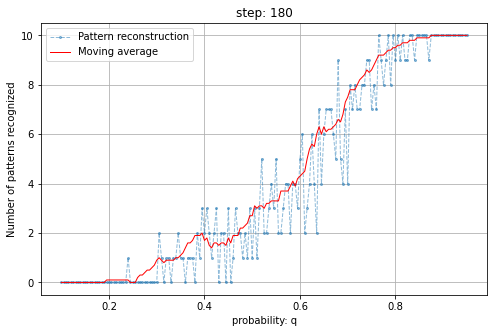

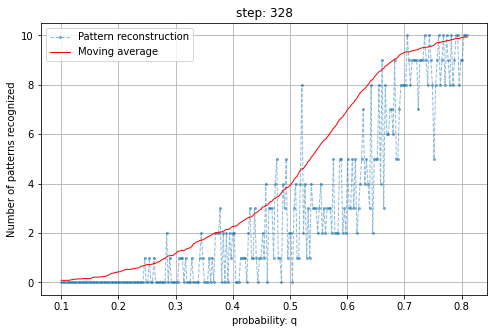

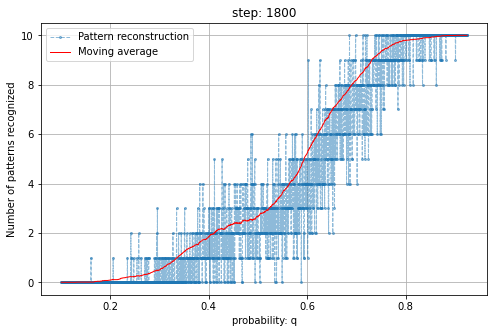

Number of pattern:25


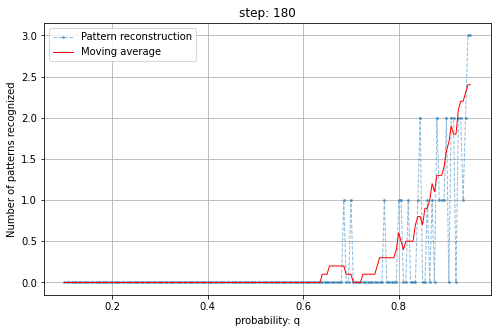

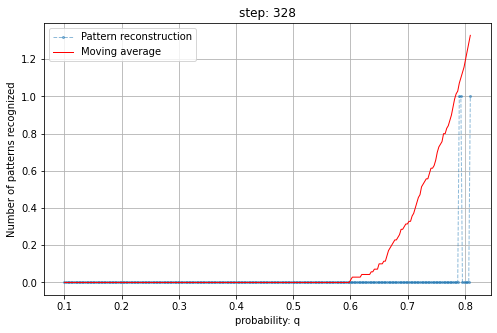

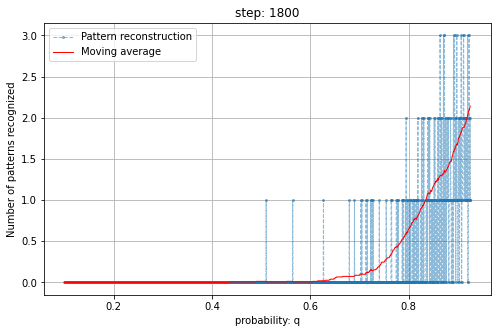

In [7]:
P = [5,10,25] #number of patterns
N = 100       #number of spins per patterns


for l in P:
    M = Create_M(l,N)
    print("Number of pattern:%d"%l)
    J_matrix=J(M)
    step = [0.005, 0.00275, 0.0005]
    for m in step:
        plt.figure(figsize=(8,5))

        q_list     = np.arange(0.1,1,m)  
        dummy_list = []
        for i in range(0,len(q_list)):

            correct = 0
            Y_1     = Wrong_patterns(q_list[i],M)

            for j in range(0,l):
                pattern_correct, _ = Update_y(J_matrix,Y_1[j],M) 
                if pattern_correct==-1:
                    pass
                else:
                    correct += 1           
            dummy_list.append(correct)
        if m==step[0]:
            avg = mov_avg(dummy_list,10)
            plt.plot(q_list[:-9],dummy_list[:-9], marker='o', linestyle='dashed',linewidth=1, markersize=2,label ='Pattern reconstruction', alpha=0.5)
            plt.ylabel('Number of patterns recognized')
            plt.xlabel('probability: q')
           
            plt.title("step: %d"%len(q_list))
            plt.plot(q_list[:-9],avg[:-9],linewidth=1,  label = "Moving average", c = "r" )
            plt.legend(prop={'size': 10})
            plt.grid()
            plt.show()
        elif m==step[1]:
            avg = mov_avg(dummy_list,70)
            plt.plot(q_list[:-69],dummy_list[:-69],marker='o', linestyle='dashed',linewidth=1, markersize=2,label ='Pattern reconstruction',alpha=0.5)
            plt.ylabel('Number of patterns recognized')
            plt.xlabel('probability: q')
            plt.title("step: %d"%len(q_list))
            plt.plot(q_list[:-69],avg[:-69], linewidth=1,  label = "Moving average", c = "r")
            plt.legend(prop={'size': 10})
            plt.grid()
            plt.show()
        elif m==step[2]:
            avg = mov_avg(dummy_list,150)
            plt.plot(q_list[:-149],dummy_list[:-149],marker='o', linestyle='dashed',linewidth=1, markersize=2,label = 'Pattern reconstruction',alpha=0.5)
            plt.ylabel('Number of patterns recognized')
            plt.xlabel('probability: q')
            plt.title("step: %d"%len(q_list))
            plt.plot(q_list[:-149],avg[:-149],linewidth=1,label = "Moving average", c = "r")
            plt.legend(prop={'size': 10})
            plt.grid()
            plt.show()

We can see that, in order to recognize the majority of the patterns, we need $q>0.6$ in case of 5 pattern, and $q>0.7$ in case of 10 patterns. Otherwise, the model can barely recognize all the patterns.

The model, indeed, doesn't work if the number of patterns increases. We can see this in the case of 25 patterns where with an accuracy of $99,95\%$ we can't recover more than 3 patterns. So we can say that this model doesn't work where the number of patterns is comparable with the number of spins. 

The red line in the plots is the moving average of the number of  recognized patterns, we used it because the data are really oscillating in the short term. We can see that, increasing the number of steps, the number of recognized patterns tends to saturate at the maximum number of patterns.

# Hopfield model for MNIST Handwritten dataset

Now we are going to implement the Hopfield model in case of MNIST Handwritten dataset. We have $10$ patterns (one for each number $0-9$) of $28\times28$ pixels. Original images are in greyscale: we converted it to black and white, where $+1$ is for white pixels, $-1$ is for black pixels.
This case is different from the previous one because now our patterns are defined by a matrix (even if we represent it in a vector, according to Hopfield model). So it's useful to try different kind of $J$, for example we can neglect the interactions between far pixels.

These functions used to crop the images and to import handwritten images from MNIST dataset.

$K$ is used to define which number we want to import.
We can define a crop factor along axis $x$ and $y$.

In [8]:
def Crop(crop_x,crop_y,M,K = []):  #this function is used only in the Input_mnist function
    
    M_inv = np.zeros((28,28,len(K)))
    for i in range(len(K)):
        M_inv[:,:,i] = M[i].reshape(28,28)
        
    return M_inv[crop_x:28-crop_x,crop_y:28-crop_y,:]

def Input_mnist(crop_x,crop_y,K = []):
    
    (X, y), (k,h) = mnist.load_data()
    
                                     # Define patterns
    M    = np.zeros((len(K),28*28))
    l    = 0
    flag = 0
    for i in K:
        for j in range(np.size(y)):
            if y[j]==i:
                if flag == 0:
                    m = j
                    M[l,:] = np.ravel(X[j,:,:]) 
                    flag = 1
                    l   += 1
        flag = 0
    
                                    #greyscale to -1 and +1
    for i in range(len(K)):
        M[i] /= np.max(M[i])
        
        
    mask     = M <= 0.5
    M[mask]  = -1
    M[~mask] = 1
    
                                    #create and crop M
    M_mat = Crop(crop_x,crop_y,M,K)
    M = np.zeros((len(K),(28-2*crop_x)*(28-2*crop_y)))
    for i in range(0,len(K)):
        M[i,:] = np.ravel(M_mat[:,:,i]) 
        
    return M                        #return a matrix that for rows have the patterns

This function is used to plot the images.

In [9]:
def Plot(crop_x,crop_y,M,K = []): 
    
    num_row = 2
    num_col = 5
    M_inv = np.zeros((28-2*crop_x,28-2*crop_y,len(K)))
    for i in range(0,len(K)):
        M_inv[:,:,i] = M[i].reshape(28-2*crop_x,28-2*crop_y)
    fig, axes = plt.subplots(num_row, num_col,figsize=(2*num_col,3*num_row))
    for j in range(len(K)):
        ax = axes[j//num_col, j%num_col]
        ax.imshow(M_inv[:,:,j], cmap = plt.get_cmap('gray'))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xticklabels([])
        ax.set_yticklabels([])

    plt.show()

Standard $J$, already used in vectors case.

In [10]:
def J(M):
    
    matrix_dim = M.shape
    J = np.zeros((matrix_dim[1],matrix_dim[1]))     #J is a matrix numberspins X numberspins

    for i in range(0,matrix_dim[1]):
        for j in range(0,matrix_dim[1]):
            if j!=i:
                J[i,j] = np.sum([M[a,i]*M[a,j] for a in range(0,matrix_dim[0])])/matrix_dim[1]
                
    return J

These functions are used for the computation of $J$ made by just nearest neighbours interactions. We can set the distance $d$ of the range of interactions. Later we set $d=2$ because we find out that this is the best approach.

Starting from original $J$, Interaction function set equal to 0 index that are at distance more than $d$.

In [11]:
def Distance(i,j,k,l):   #distances between 4 index
    dist = np.sqrt((k-i)*(k-i)+(l-j)*(l-j))
    
    return dist

def Interaction(J,n,d):
    
    for i in range(n):
        for j in range(n):
            for k in range(n):
                for l in range(n):
                    dist=Distance(i,j,k,l)
                    
                    if dist>=d:
                        a = i*n+j
                        b = k*n+l
                        J[a,b] = 0
                        
    return J

This function compute a matrix $Y$ of the same shape of $M$ matrix but that has corrupted pattern inside. The grade of corruption is linked to the parameter $q$.

In [12]:
def Wrong_patterns(q,M):
 
    Y = np.zeros((M.shape))

    for i in range(0,M.shape[0]):
        x = M[i,:]

        for j in range(0,M.shape[1]):
            rand = np.random.random_sample()
            if rand<=q:
                Y[i,j] = x[j]
            else:
                Y[i,j] = -x[j]
        
    return Y

Function used to update $y$ based on Hopfield Model. It returns the pattern detected or $-1$ if it cannot detects any patterns. It returns also the number of iterations done before reaching convergence. The algorithms stops itself when the new $y$ is equal to the previous $y$ after a loop of the spins. $Conf$ is the parameter that evaluates the confidence of the pattern and the restored image.

In [13]:
def Update_y(J,y,M, conf = 10, iter_max = 100):
    flag = 1
    t    = 0 #iteration 
    
    y_old    = np.zeros(len(y))
    y_old[:] = y[:]
    while(flag and t <= iter_max):

        for i in range(J.shape[1]):
            y[i] = np.sign(np.dot(J[i,:],y))     #if y_i= 0 --> sign(0) = 0 --> y_i = 1
            if (y[i] == 0):
                y[i] = 1

        t += 1
        k  = 0
        for j in range(0,len(y)):                #comparison with y_old 
            if(y[j] == y_old[j]):
                k += 1
        if k==len(y):
            flag = 0
        else:
            y_old[:] = y[:]
                
                                                # Pattern of y updated
    P_a = -1
    if (flag == 0):
        
        for i in range(M.shape[0]):
            k = 0
            l = 0                               #number of white pixels
            for j in range(0,len(y)):
                if M[i,j] == -1:
                    l += 1
                if(y[j] == M[i,j]):
                    k += 1
            if k >= (1-(conf/100))*len(y):
                P_a = i
                
    return P_a,t

This function determines the number of detected pattern by the function `Update_y` using a $q$ loop based on different $q$ value. It puts this number in a list.

In [14]:
def Detected_patterns_func(M,K,J,conf,q_list=[]):
    
    detected_patterns = []
    
    for i in range(0,len(q_list)):
        
        t = 0
        Y = Wrong_patterns(q_list[i],M)
    
        for j in range(0,len(K)):
            detected_pattern, iteration = Update_y(J,Y[j],M,conf) 
            if detected_pattern == -1:
                pass
            else:
                t += 1
            
        detected_patterns.append(t)
        
    return detected_patterns   #it is a list 

# 1) Original images

In this section we evaluate Hopfield Model using the original images $28\times28$.

In [15]:
K = [0,1,2,3,4,5,6,7,8,9]      #we took all the patterns
crop_x = 0
crop_y = 0 

M = Input_mnist(crop_x,crop_y,K)
M = np.array(M,dtype=np.float64) 
J_matrix = J(M)

We try to use 10 patterns and we create a matrix of corrupted patterns, named $Y$, with $q=0.99$; so our $Y$ is very similiar to $M$, the original one.

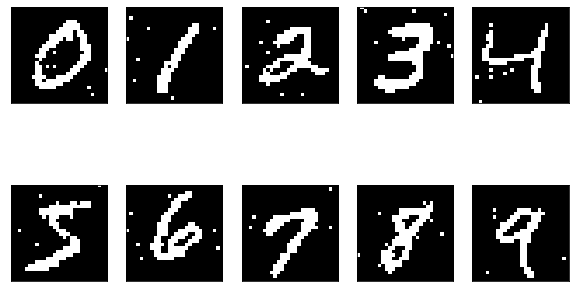

In [16]:
Y = Wrong_patterns(0.99,M)

Plot(crop_x,crop_y,Y,K) #here the corrupted patterns

We reconstruct the original pattern using the function Update_y with a grade of confidence of 5%.

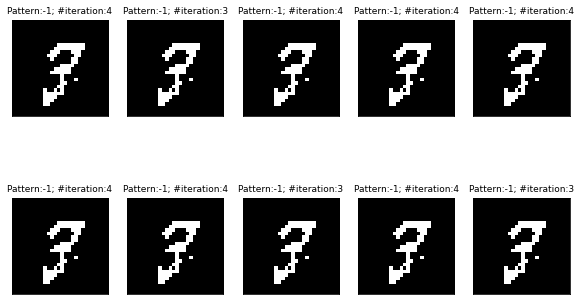

In [17]:
#Recover the patterns without the nn interaction
a = []
it = []

for j in range(0,len(K)):
    detected_pattern, iteration = Update_y(J_matrix,Y[j],M, conf = 5)
    a.append(detected_pattern)
    it.append(iteration)
    
num_col = 5
num_row = len(K)//num_col
Y_inv = np.zeros((28-2*crop_x,28-2*crop_y,len(K)))

for i in range(0,len(K)):
    Y_inv[:,:,i] = Y[i].reshape(28-2*crop_x,28-2*crop_y)
fig, axes = plt.subplots(num_row, num_col,figsize=(2*num_col,3*num_row))

for j in range(len(K)):
    ax = axes[j//num_col, j%num_col]
    ax.imshow(Y_inv[:,:,j], cmap = plt.get_cmap('gray'))
    ax.set_title("Pattern:%d; #iteration:%d"%(a[j],it[j]), fontsize = 9)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
plt.show()
 

In this case, we observe that we are not able to find any pattern using the reconstruction of Hopfield Model.
We can try with different number of patterns. We have observed that with $N>2$ we can't recognize any patterns. This is because we have too many informations.

Let's show $N=2$.

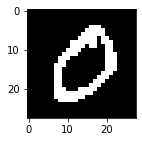

Pattern detected:  0 in  2 iterations 



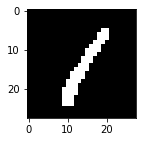

Pattern detected:  1 in  2 iterations 



In [18]:
K      = [0,1] #we took 2 patterns
crop_x = 0
crop_y = 0

M = Input_mnist(crop_x,crop_y,K)
J_matrix = J(M)

Y = Wrong_patterns(0.99,M)

for j in range(0,len(K)):
    detected_pattern, iteration = Update_y(J_matrix,Y[j],M, conf =5)
    
    M_inv = np.zeros((28-2*crop_x,28-2*crop_y,len(K)))
    M_inv[:,:,j] = Y[j].reshape(28-2*crop_x,28-2*crop_y)
    plt.figure(figsize = (20,2))
    plt.imshow(M_inv[:,:,j], cmap=plt.get_cmap('gray'))
    plt.show()
    
    if detected_pattern==-1:
        print('No pattern detected in:', iteration, 'iterations \n')
    else:
        print('Pattern detected: ', detected_pattern, 'in ', iteration, 'iterations \n')

# 2) Crop images

We try the same thing as before, but this time we crop the images one row of pixels for step. We try this method because we think we have too many useless information in the black pixels. We still use $10$ patterns.

We keep trace of the number of detected patterns for step in database_detected_patterns list.

In [19]:
K = [0,1,2,3,4,5,6,7,8,9]
database_detected_patterns=[]

for x in range(0,10):

    crop_x = x
    crop_y = x

    M = Input_mnist(crop_x,crop_y,K)
    M = np.array(M,dtype = np.float64)
    J_matrix = J(M)
    q_list = [0.9]

    database_detected_patterns.append(Detected_patterns_func(M,K,J_matrix,5,q_list))

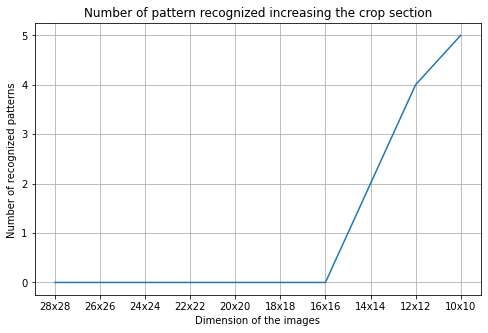

In [20]:
x = np.arange(14,4,-1)
plt.figure(figsize = (8,5))
plt.plot(-2*x,database_detected_patterns)
plt.ylabel('Number of recognized patterns ')
plt.xlabel('Dimension of the images')
plt.xticks(-np.arange(10, 29, step=2),('10x10', '12x12', '14x14', '16x16', '18x18', '20x20', '22x22', '24x24', '26x26','28x28'))
plt.title('Number of pattern recognized increasing the crop section')
plt.grid()
plt.show()

At this point, we see that a $14\times14$ pixel image we start recognize some patterns. The problem is that we can't visualize correctly some numbers anymore. For example, we lost important information (white pixels) on $0,3,4,6$.

Let's show  $12\times12$ images:

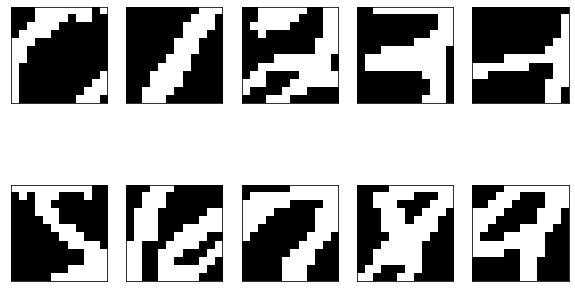

In [21]:
K = [0,1,2,3,4,5,6,7,8,9]
crop_x = 8
crop_y = 8

M = Input_mnist(crop_x,crop_y,K)

Plot(crop_x,crop_y,M,K)

So we decide to use $14\times14$ pixel images so we have more information on more number, even if it works worse.

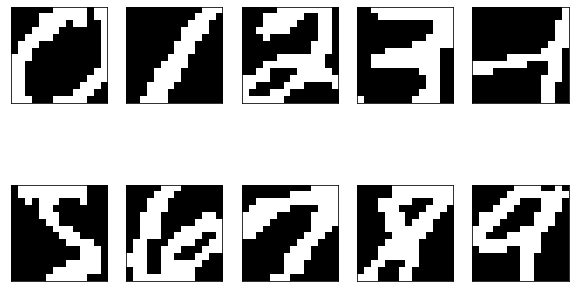

In [22]:
K = [0,1,2,3,4,5,6,7,8,9]
crop_x = 7
crop_y = 7

M = Input_mnist(crop_x,crop_y,K)

Plot(crop_x,crop_y,M,K)

# 3) Crop and vary K

Here we kept $14\times14$ images and we keep trace of detected patterns while we change numbers of patterns $K$. We have fixed the probability $q=0.6$.

Database detected patterns list is the list of detected patterns for different $K$.

Database is the list of database detected patterns list. We have worked in this way because we have few step, so it's useful to iterate this process for many times (10 in this case), and then calculate the mean over the columns. 

In [23]:
Database = []

for k in range(0,10):
    K = [0]
    database_detected_patterns=[]
    
    for x in range(1,10):

        crop_x = 7
        crop_y = 7
        
        K.append(x)

        M = Input_mnist(crop_x,crop_y,K)
        J_matrix = J(M)
        q_list   = [0.6]

        database_detected_patterns.append(Detected_patterns_func(M,K,J_matrix,5,q_list))
        
    Database.append(database_detected_patterns)

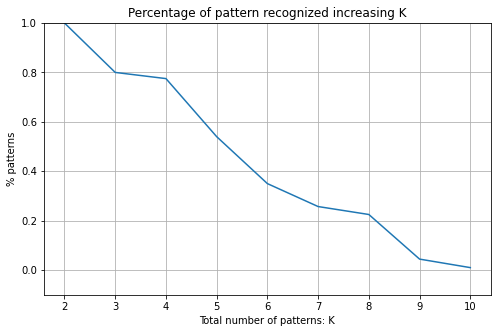

In [24]:
mean_arr = np.mean(Database, axis = 0)
res = mean_arr.reshape(1,9)
plt.figure(figsize = (8,5))
x = np.arange(2,11)
y = np.zeros(res.shape)
y[:] = res[:]/x[:]

plt.plot(x,y.T)  
plt.ylabel('% patterns')
plt.xlabel('Total number of patterns: K')
plt.title('Percentage of pattern recognized increasing K')
plt.grid()
plt.ylim((-0.1,1.0))
plt.show()

At this probability we observe that if we have more than $5$ patterns, we are not able to recognize any.

For this $q$, if we want to detect more corrupted patterns starting from more than $5$ patterns, we have to introduce another method. We now use the corrected $J$, that neglect the interaction between far pixels.

# 4) Crop and nearest neighbor J

Now we consider crop $14\times14$ and corrected $J$. This is the best soluction found by ourself. 

We keep trace of detected pattern while varying $q$.

In [25]:
K = [0,1,2,3,4,5,6,7,8,9]
crop_x = 7
crop_y = 7

M = Input_mnist(crop_x,crop_y,K)
M = np.array(M,dtype = np.float64)

J_matrix = J(M)

A = np.zeros((J_matrix.shape[0],J_matrix.shape[1]))
A[:,:] = J_matrix[:,:]
J_new  = Interaction(A,(28-2*crop_y),2)

Here we do $10$ loop and we calculate the mean over the columns, while varying $q$. Notice that we are considering all the $10$ patterns.

In [26]:
#nearest neighbours interaction

q_list = np.arange(0.1,1,0.005)

database_detected_patterns=[]
for k in range(0,10):
    database_detected_patterns.append(Detected_patterns_func(M,K,J_new,10,q_list))

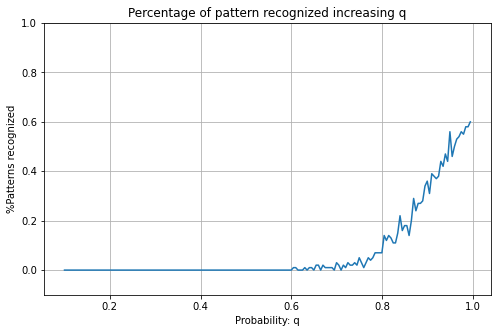

In [27]:
mean_arr = np.mean(database_detected_patterns, axis=0)/10

plt.figure(figsize = (8,5))
plt.plot(q_list,mean_arr)
plt.ylabel('%Patterns recognized')
plt.title('Percentage of pattern recognized increasing q')
plt.xlabel('Probability: q')
plt.grid()
plt.ylim((-0.1,1.0))
plt.show()

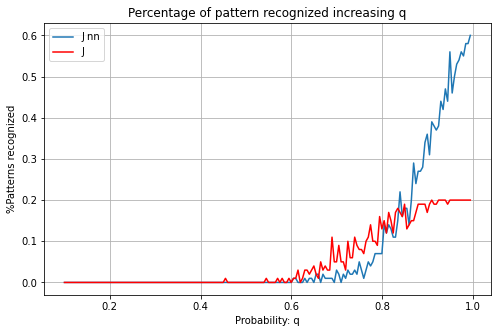

In [28]:
q_list_1 = np.arange(0.1,1,0.005)

database_detected_patterns_1=[]
for k in range(0,10):
    database_detected_patterns_1.append(Detected_patterns_func(M,K,J_matrix,10,q_list))

mean_arr_1 = np.mean(database_detected_patterns_1, axis=0)/10


plt.figure(figsize = (8,5))
plt.plot(q_list,mean_arr, label = "J nn")
plt.plot(q_list_1,mean_arr_1, label = "J", c = "r")
plt.ylabel('%Patterns recognized')
plt.title('Percentage of pattern recognized increasing q')
plt.xlabel('Probability: q')
plt.grid()
plt.legend()
plt.show()

We observe that using $J_{new}$ (the one with just nearest neighbours interaction), we achieve better results respect to using the standard $J$. In particular, standard $J$ saturizes at 2 recognized patterns, even with $q=0.99$.

Let's show the reconstruction of the images by $J$ and $J_{new}$. We use crop factor equal to 5 to achieve better images.

In [29]:
crop_x = 5
crop_y = 5

M = Input_mnist(crop_x,crop_y,K)
M = np.array(M,dtype = np.float64)

J_matrix = J(M)

A = np.zeros((J_matrix.shape[0],J_matrix.shape[1]))
A[:,:] = J_matrix[:,:]
J_new  = Interaction(A,(28-2*crop_y),2)

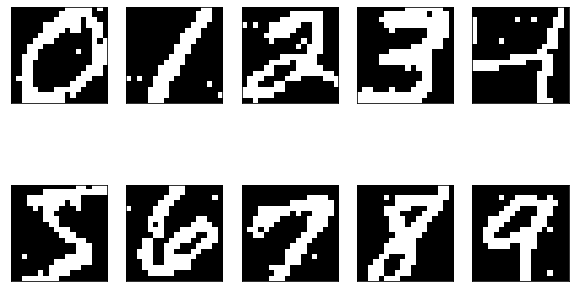

In [30]:
Y_1 = Wrong_patterns(0.99,M)
Y_2=np.zeros(Y_1.shape)
Y_2[:]=Y_1[:]

Plot(crop_x,crop_y,Y_1,K)

Detected patterns using standard J


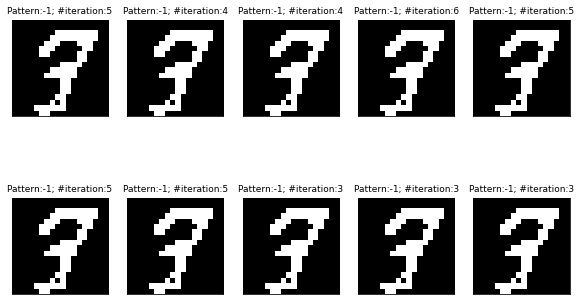

Detected patterns using J_new


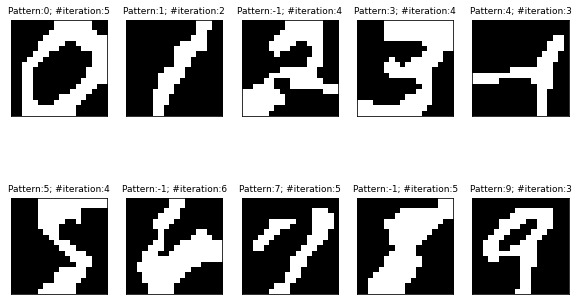

In [31]:
a = []
it = []
print('Detected patterns using standard J')
for j in range(0,len(K)):
    detected_pattern, iteration = Update_y(J_matrix,Y_1[j],M, conf = 10)
    a.append(detected_pattern)
    it.append(iteration)
    
num_col = 5
num_row = len(K)//num_col
Y_inv = np.zeros((28-2*crop_x,28-2*crop_y,len(K)))

for i in range(0,len(K)):
    Y_inv[:,:,i] = Y_1[i].reshape(28-2*crop_x,28-2*crop_y)
fig, axes = plt.subplots(num_row, num_col,figsize=(2*num_col,3*num_row))

for j in range(len(K)):
    ax = axes[j//num_col, j%num_col]
    ax.imshow(Y_inv[:,:,j], cmap = plt.get_cmap('gray'))
    ax.set_title("Pattern:%d; #iteration:%d"%(a[j],it[j]), fontsize = 9)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
plt.show()
 

a = []
it = []
print('Detected patterns using J_new')
for j in range(0,len(K)):
    detected_pattern, iteration = Update_y(J_new,Y_2[j],M, conf = 10)
    a.append(detected_pattern)
    it.append(iteration)
    
num_col = 5
num_row = len(K)//num_col
Y_inv = np.zeros((28-2*crop_x,28-2*crop_y,len(K)))

for i in range(0,len(K)):
    Y_inv[:,:,i] = Y_2[i].reshape(28-2*crop_x,28-2*crop_y)
fig, axes = plt.subplots(num_row, num_col,figsize=(2*num_col,3*num_row))

for j in range(len(K)):
    ax = axes[j//num_col, j%num_col]
    ax.imshow(Y_inv[:,:,j], cmap = plt.get_cmap('gray'))
    ax.set_title("Pattern:%d; #iteration:%d"%(a[j],it[j]), fontsize = 9)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
plt.show()